Load dataset

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

path = '../data/dataset.csv'

df = pd.read_csv(path, index_col=0)
display(df.head())
print(len(df))

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


114000


Top 15 Most Popular Genres

In [5]:
df = df.drop_duplicates(subset=["track_id"], keep="first")
df = df.drop_duplicates(subset=["artists", "track_name"], keep="first")
df = df.reset_index(drop=True)

used_features = ["track_id", "artists", "track_name", "acousticness", "danceability", "energy",
                 "key", "speechiness", "loudness", "instrumentalness", "tempo", "track_genre", "valence", "popularity"]
df = df[used_features].copy()

df["tempo"] = pd.to_numeric(df["tempo"], errors="coerce")
df = df[df["tempo"] > 0]

num_cols = ["danceability","energy","key","speechiness","instrumentalness","tempo",
            "acousticness","loudness","valence"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")
    df[c] = df[c].fillna(df[c].median())

genre_cat = df["track_genre"].astype("category")
num_genres = len(genre_cat.cat.categories)

def one_hot(idx, num_classes):
    v = np.zeros(num_classes, dtype=float)
    v[idx] = 1.0
    return v

df["track_genre"] = genre_cat.cat.codes.apply(
    lambda i: one_hot(i, num_genres)
)

scale_cols = ["danceability","energy","loudness","speechiness",
              "acousticness","instrumentalness","valence","tempo"]
for c in scale_cols:
    mu, sd = df[c].mean(), df[c].std()
    if sd > 0:
        df[c] = (df[c] - mu) / sd

print("Clean rows:", len(df))

Clean rows: 81199


The distribution of track popularity

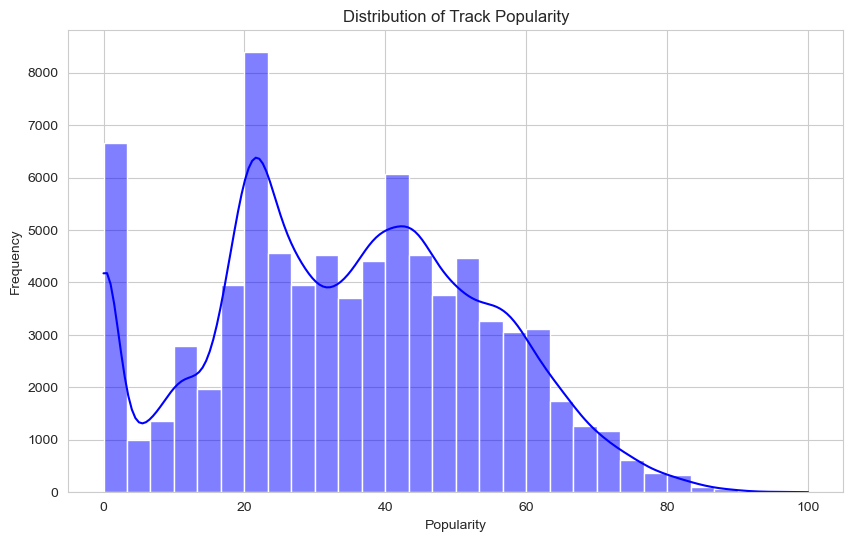

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(df['popularity'], bins=30, kde=True, color='blue')
plt.title('Distribution of Track Popularity')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.show()

The relationship between energy and loudness

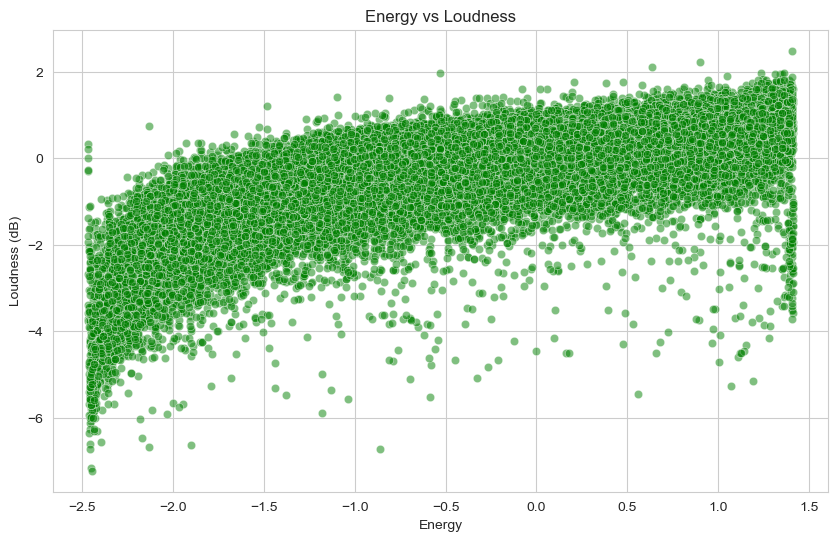

In [7]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='energy', y='loudness', data=df, alpha=0.5, color='green')
plt.title('Energy vs Loudness')
plt.xlabel('Energy')
plt.ylabel('Loudness (dB)')
plt.show()

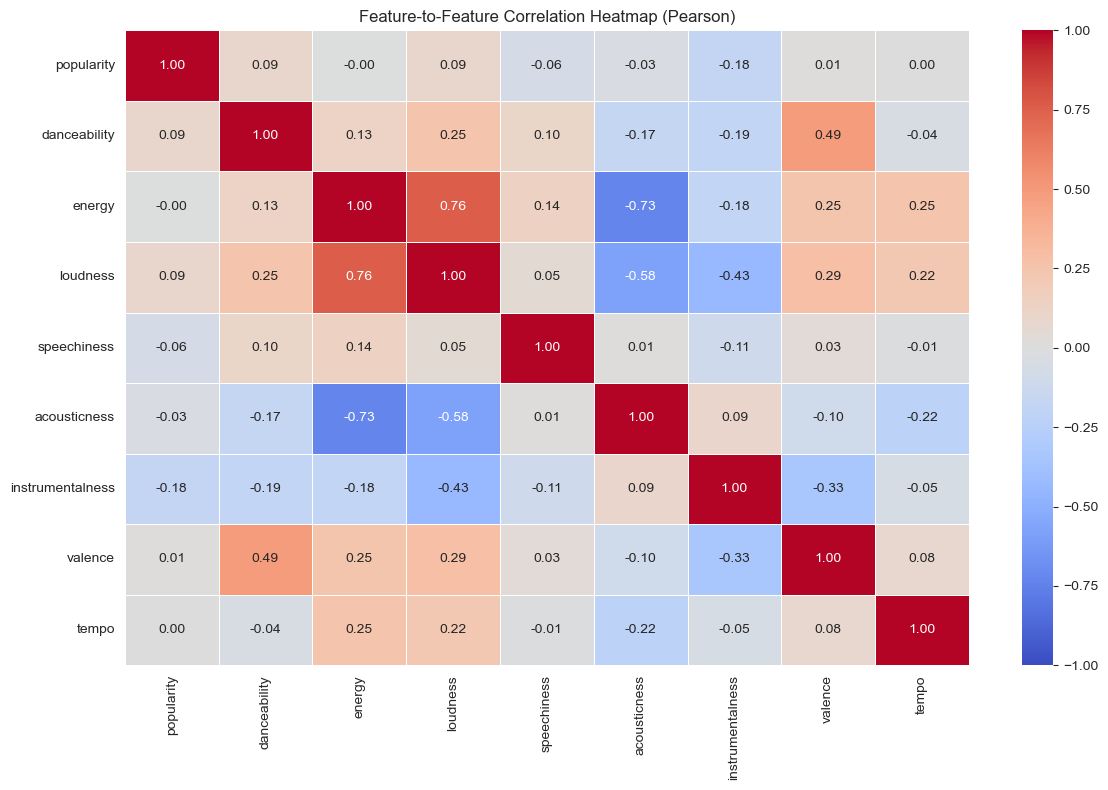

In [8]:
import seaborn as sns

features = [
    'popularity','duration_ms','danceability','energy','loudness','speechiness',
    'acousticness','instrumentalness','liveness','valence','tempo'
]
features = [c for c in features if c in df.columns]

sub = df[features].apply(pd.to_numeric, errors='coerce')
for c in features:
    sub[c] = sub[c].fillna(sub[c].median())

corr = sub.corr(method='pearson')

plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm', center=0, vmin=-1, vmax=1, annot=True, fmt='.2f', linewidths=0.5)
plt.title('Feature-to-Feature Correlation Heatmap (Pearson)')
plt.tight_layout()
plt.show()

Top 3 strongest positive correlations:
·Loudness ↔ Energy — louder tracks tend to be more energetic.
·Valence ↔ Danceability — happier-sounding tracks tend to be more danceable.
·Valence ↔ Loudness — happier-sounding tracks tend to be louder.
    
From correltion heatmap, popularity does not have significant correlation with other features.

Top 10 most frequent artists

/var/folders/70/xcmvqsj57kj0hhxl81k3t4s40000gn/T/ipykernel_5637/752989934.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_artists.values, y=top_artists.index, palette='viridis')


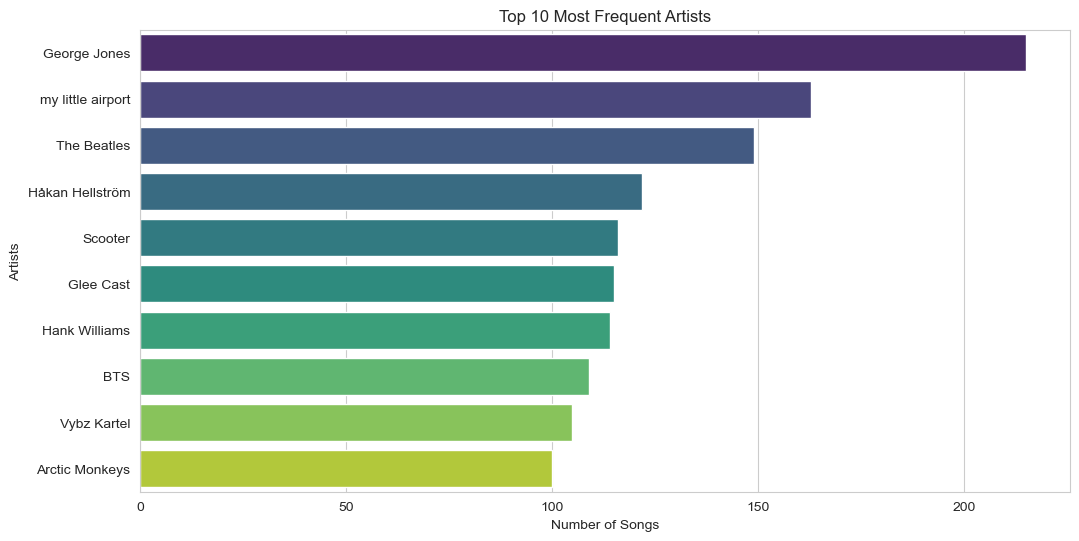

In [9]:
top_artists = df['artists'].value_counts().head(10)

# plot the top 10 artists
plt.figure(figsize=(12, 6))
sns.barplot(x=top_artists.values, y=top_artists.index, palette='viridis')
plt.title('Top 10 Most Frequent Artists')
plt.xlabel('Number of Songs')
plt.ylabel('Artists')
plt.show()

Plotting various columns vs popularity

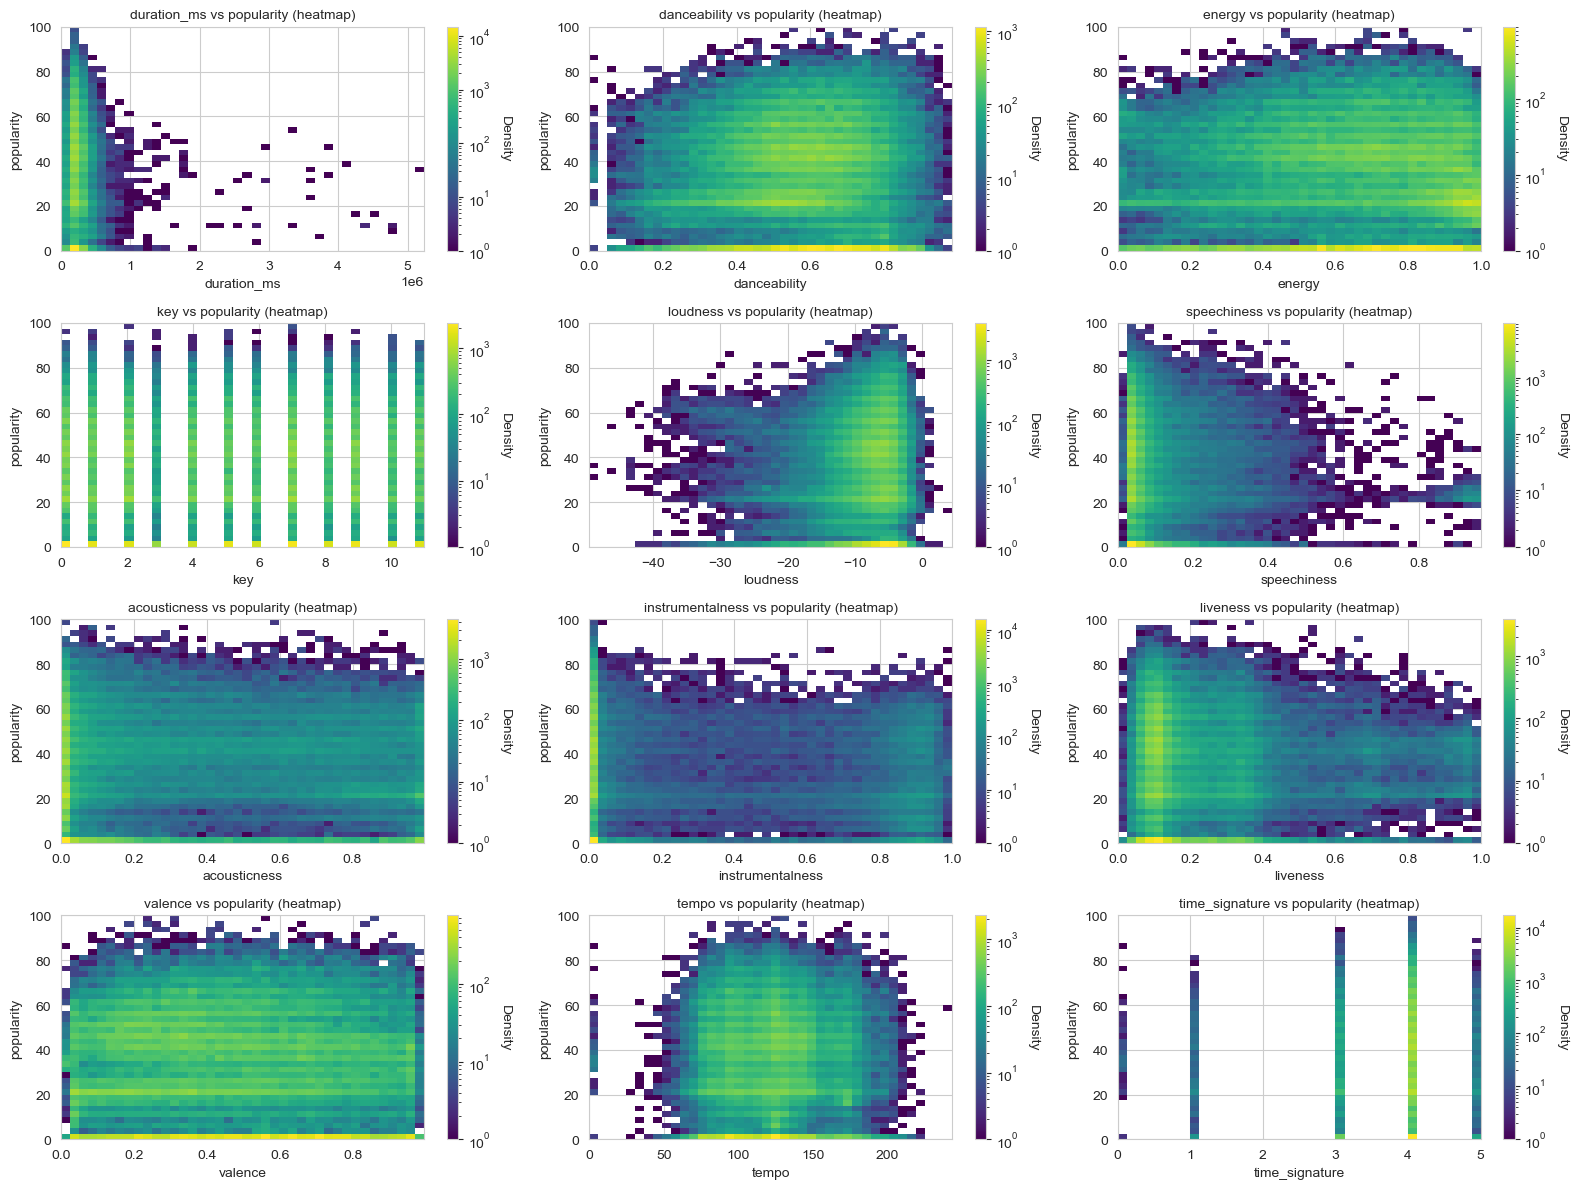

In [11]:
columns = [
    "duration_ms", "danceability", "energy", "key", "loudness",
    "speechiness", "acousticness", "instrumentalness", "liveness",
    "valence", "tempo", "time_signature"
]
target = "popularity"

fig, axes = plt.subplots(4, 3, figsize=(16, 12))
axes = axes.flatten()
for i, col in enumerate(columns):
    ax = axes[i]
    hm = ax.hist2d(df[col], df[target], bins=40, cmap='viridis', norm=LogNorm())
    ax.set_title(f"{col} vs {target} (heatmap)", fontsize=10)
    ax.set_xlabel(col)
    ax.set_ylabel(target)
    bar = plt.colorbar(hm[3], ax=ax)
    bar.set_label("Density", rotation=270, labelpad=15)
plt.tight_layout()
plt.show()

In [15]:
def plot_scatter(targets, results):
    fig, axes = plt.subplots(4, 3, figsize=(16, 12))
    axes = axes.flatten()

    target_mask = df.apply(lambda row: (row["artists"], row["track_name"]) in targets, axis=1)
    result_mask = df.apply(lambda row: (row["artists"], row["track_name"]) in results, axis=1)

    for i, col in enumerate(columns):
        ax = axes[i]
        ax.scatter(df[col], df[target], alpha=0.01, s=10)
        ax.scatter(
            df.loc[target_mask, col],
            df.loc[target_mask, target],
            color="red",
            s=40,
            label="Targets",
            alpha=0.9
        )

        ax.scatter(
            df.loc[result_mask, col],
            df.loc[result_mask, target],
            color="blue",
            s=40,
            label="Results",
            alpha=0.9
        )
        ax.set_title(f"{col} vs {target}", fontsize=10)
        ax.set_xlabel(col)
        ax.set_ylabel(target)
        ax.legend()
    plt.tight_layout()
    plt.show()

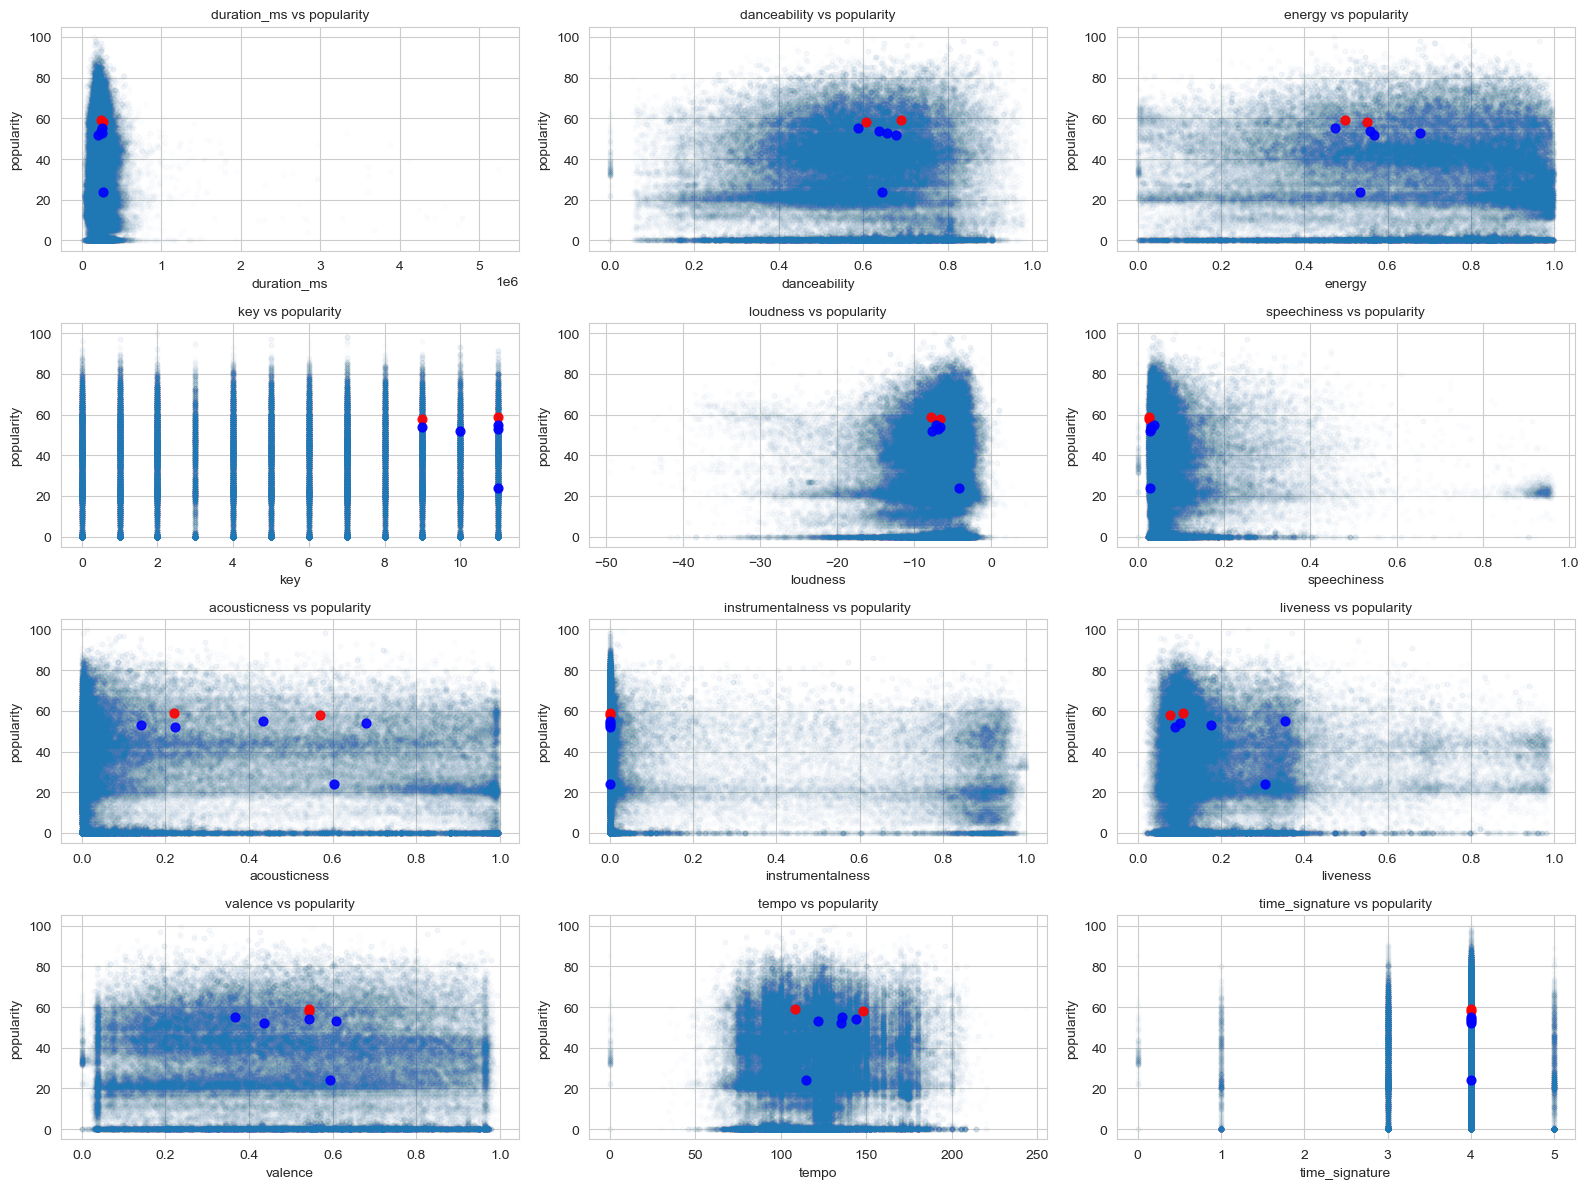

In [16]:
plot_scatter([('Jay Chou', '青花瓷'), ('David Tao', '就是愛妳')], )